## Local Linear Forest


In [215]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor

class LocalLinearForestRegressor(RandomForestRegressor):
    def __init__(self,
                 n_estimators=500,
                 criterion='squared_error',
                 max_depth=10,
                 min_samples_split=3,
                 min_samples_leaf=2,
                 min_weight_fraction_leaf=0.,
                 max_features=0.7,
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.01,
                 bootstrap=True,
                 oob_score=False,
                 n_jobs=-1,
                 random_state=None,
                 verbose=0,
                 warm_start=True,
                 lam = 1,
                 max_samples = 0.5):
        super().__init__(n_estimators=n_estimators,
                         criterion=criterion,
                         max_depth=max_depth,
                         min_samples_split=min_samples_split,
                         min_samples_leaf=min_samples_leaf,
                         min_weight_fraction_leaf=min_weight_fraction_leaf,
                         max_features=max_features,
                         max_leaf_nodes=max_leaf_nodes,
                         min_impurity_decrease=min_impurity_decrease,
                         bootstrap=bootstrap,
                         oob_score=oob_score,
                         n_jobs=n_jobs,
                         random_state=random_state,
                         verbose=verbose,
                         warm_start=warm_start,
                         max_samples = max_samples)

        self._incidence_matrix = None
        self._X_train_split = None
        self._X_train_ridge = None
        self._Y_train = None
        self.lam = lam

    def _extract_leaf_nodes_ids(self, X):
        leafs = [e.apply(X).reshape(-1, 1) for e in self.estimators_]
        leaf_nodes_ids = np.concatenate(leafs, axis=1)
        assert leaf_nodes_ids.shape[0] == X.shape[0]
        assert leaf_nodes_ids.shape[1] == len(self.estimators_)
        return leaf_nodes_ids

    def fit(self, X_split, y, X_ridge = None, sample_weight=None):
        super().fit(X_split, y, sample_weight=sample_weight)
        self._X_train_split = X_split
        self._X_train_ridge = X_ridge
        self._Y_train = y
        self._incidence_matrix = self._extract_leaf_nodes_ids(X_split)
        return self

    def _get_forest_coefficients(self, observation_leaf_ids):
        coeffs = np.zeros(self._X_train_split.shape[0])
        for j in range(observation_leaf_ids.shape[1]):
            matching_nodes = (self._incidence_matrix[:, j] == observation_leaf_ids[0, j])
            counts = np.sum(matching_nodes)
            if counts > 0:
                coeffs += matching_nodes / counts
        return coeffs / self.n_estimators

    def predict_LLF(self, X_test_split, X_test_ridge):
        results = []
        X_test_split = np.array(X_test_split)
        X_test_ridge = np.array(X_test_ridge)

        for i in range(X_test_split.shape[0]):
            x0_split = X_test_split[i, :].reshape(1, -1)
            x0_ridge = X_test_ridge[i, :].reshape(1, -1)
            actual_leaf_ids = self._extract_leaf_nodes_ids(x0_split)
            alpha_i = self._get_forest_coefficients(actual_leaf_ids)

            Delta = np.hstack([np.ones((self._X_train_ridge.shape[0], 1)), self._X_train_ridge - x0_ridge])
            A = np.diag(alpha_i)
            d = self._X_train_ridge.shape[1]
            J = np.diag([0] + [1] * d)

            inv_term = np.linalg.inv(Delta.T @ A @ Delta + self.lam * J)
            theta_hat = inv_term @ Delta.T @ A @ self._Y_train

            u_hat = theta_hat[0]
            results.append(u_hat)

        return np.array(results).reshape(-1)

## Random Forest

In [7]:
from sklearn.ensemble import RandomForestRegressor

def train_test_rf(X_train, Y_train, X_test, n_estimators = 500, max_depth = 10, max_features = 0.7, min_samples_split = 4, min_samples_leaf = 2):
    forest = RandomForestRegressor(n_estimators= n_estimators, max_depth= max_depth, max_features = max_features, 
                                   min_samples_split = min_samples_split, min_samples_leaf= min_samples_leaf, n_jobs= -1)
    forest.fit(X_train, Y_train)
    predictions = forest.predict(X_test)

    return predictions


## GJR-GARCH

In [8]:
!pip install arch

from arch import arch_model

def predict_GJR(Y_train, oos):
    # Specify GJR-GARCH(1,1) model
    model = arch_model(Y_train, vol='GARCH', p=1, o=1, q=1)

    # Fit the model
    model_fit = model.fit(disp='off')

    if(oos):
      # Make one-step-ahead forecast
      forecast = model_fit.forecast(horizon=1)
      # Get the forecasted conditional volatility
      forecasted_volatility = np.sqrt(forecast.variance.values[-1][-1])

      return forecasted_volatility

    else:
      in_sample_fitted_values = np.sqrt(model_fit.conditional_volatility)
      print("GJR estimates:", model_fit.params)

      return in_sample_fitted_values

## GARCH(1,1)

In [9]:
def predict_GARCH(returns, oos):
    # Create GARCH(1,1) model
    model = arch_model(returns, vol='Garch', p=1, q=1)

    # Fit the model
    model_fit = model.fit(disp='off')

    if(oos):
      # Make one-step-ahead forecast
      forecast = model_fit.forecast(horizon=1)
      # Get the forecasted conditional volatility
      forecasted_volatility = np.sqrt(forecast.variance.values[-1][-1])

      return forecasted_volatility

    else:
      in_sample_fitted_values = np.sqrt(model_fit.conditional_volatility)
      print("GARCH estimates:", model_fit.params)

      return in_sample_fitted_values

## HAR Model

In [43]:
from sklearn.linear_model import LinearRegression
from statsmodels.tools.tools import add_constant
import pandas as pd

def predict_har(realized_volatility):
    realized_volatility = pd.DataFrame(realized_volatility, columns=['Realized Volatility'])
    rv = realized_volatility['Realized Volatility']
    df = pd.DataFrame({
        'Constant': 1,
        'RV': rv,
        'RV_day': rv.shift(1),
        'RV_weekly': rv.rolling(window=5).mean(),
        'RV_monthly': rv.rolling(window=22).mean()
    }).dropna()

    X = df[['Constant', 'RV_day', 'RV_weekly', 'RV_monthly']]
    y = df['RV']

    model = LinearRegression()
    model.fit(X, y)

    # Prepare the most recent values for prediction
    latest_Y_lagged = rv.iloc[-1]
    latest_Y_weekly = rv.rolling(window=5).mean().iloc[-1]
    latest_Y_monthly = rv.rolling(window=22).mean().iloc[-1]

    # Create a DataFrame for the most recent values
    latest_X = pd.DataFrame({
        'Constant': [1],
        'RV_day': [latest_Y_lagged],
        'RV_weekly': [latest_Y_weekly],
        'RV_monthly': [latest_Y_monthly]
    })

    # One-step-ahead prediction
    one_step_ahead_prediction = model.predict(latest_X)
    return one_step_ahead_prediction[0]

## Filepaths

In [11]:
def get_filepaths(coin):
  yearly_data = None
  hourly_data = None

  if coin == 'Bitcoin':
     yearly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_BTCEUR_d.csv"
     hourly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_BTCEUR_1h.csv"

  elif coin == "Ethereum":
     yearly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_ETHEUR_d.csv"
     hourly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_ETHEUR_1h.csv"

  elif coin == "Tether":
     yearly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_EURUSDT_d.csv"
     hourly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_EURUSDT_1h.csv"

  elif coin == "Binance Coin":
     yearly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_BNBEUR_d.csv"
     hourly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_BNBEUR_1h.csv"

  elif coin == "Bitcoin Cash":
     yearly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_BCHEUR_d.csv"
     hourly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_BCHEUR_1h.csv"

  elif coin == "Litecoin":
     yearly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_LTCEUR_d.csv"
     hourly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_LTCEUR_1h.csv"

  elif coin == "Internet Computer":
     yearly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_ICPEUR_d.csv"
     hourly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_ICPEUR_1h.csv"

  elif coin == "Polygon":
     yearly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_MATICEUR_d.csv"
     hourly_data = r"C:\Users\JNoot\Documents\University\Bachelor Thesis\Data\Binance_MATICEUR_1h.csv"

  return yearly_data, hourly_data

## Functions

In [160]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from model_confidence_set import ModelConfidenceSet
import numpy as np
from tqdm import tqdm, notebook
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from IPython.utils import io

def get_errors(predictions, Y_test):
    mse = {}
    mae = {}
    rmse = {}
    for model, pred in predictions.items():
        Y_test = Y_test.squeeze()
        mse_pred = mean_squared_error(Y_test, pred)
        mae_pred = mean_absolute_error(Y_test, pred)

        mse[model] = mse_pred
        mae[model] = mae_pred
        rmse[model] = np.sqrt(mse_pred)

    return mse, mae, rmse

def get_qlike(predictions, Y_test):
    qlikes = {}
    for model, pred in predictions.items():
        Y_test = Y_test.squeeze()
        qlike = np.mean((Y_test/pred) - np.log(Y_test/pred) - 1)
        qlikes[model] = qlike
    return qlikes

def get_mcs(predictions, Y_test, error):
    errors = {}
    for model, pred in predictions.items():
        Y_test = Y_test.squeeze()
        if error == "RMSE":
            errors[model] = (Y_test - pred)  ** 2
        elif error == "QLIKE":
            errors[model] = (Y_test/pred) - np.log(Y_test/pred) - 1
        elif error == "Utility":
            errors[model] = - (0.08 * (np.sqrt(Y_test/pred)) - 0.04 * (Y_test/pred))
    errors = pd.DataFrame(errors)

    ## Use block_len = 7 from the rule of thumb (cube root of number of observations)
    mcs = ModelConfidenceSet(errors, n_boot = 5000, alpha = 0.05, block_len= 7)
    mcs.compute()
    mcs_results = mcs.results()
    included_models = {model: (mcs_results.loc[model, 'status'] == 'included') for model in predictions.keys()}
    return included_models

def update_mcs_count(predictions, Y_test, mcs_counts_rmse=None, mcs_counts_qlike=None, mcs_counts_utility=None):
    included_models_rmse = get_mcs(predictions, Y_test, "RMSE")
    included_models_qlike = get_mcs(predictions, Y_test, 'QLIKE')
    included_models_utility = get_mcs(predictions, Y_test, "Utility")

    for model in predictions.keys():
        if included_models_rmse[model] and mcs_counts_rmse is not None:
            mcs_counts_rmse[model] += 1
        if included_models_qlike[model] and mcs_counts_qlike is not None:
            mcs_counts_qlike[model] += 1
        if included_models_utility[model] and mcs_counts_utility is not None:
            mcs_counts_utility[model] += 1

    return mcs_counts_rmse, mcs_counts_qlike, mcs_counts_utility

def plot_feature_importance(importances, feature_names, threshold=0):
    indices = np.argsort(importances)[::-1]
    significant_indices = [i for i in indices if importances[i] > threshold]
    
    plt.figure(figsize=(10, 8))
    plt.title("Feature Importances")
    plt.barh(range(len(significant_indices)), importances[significant_indices], align="center")
    plt.yticks(range(len(significant_indices)), [feature_names[i] for i in significant_indices])
    plt.gca().invert_yaxis()
    plt.xlabel('Feature Importance')
    plt.show()   

## Obtain Data

Internet Computer


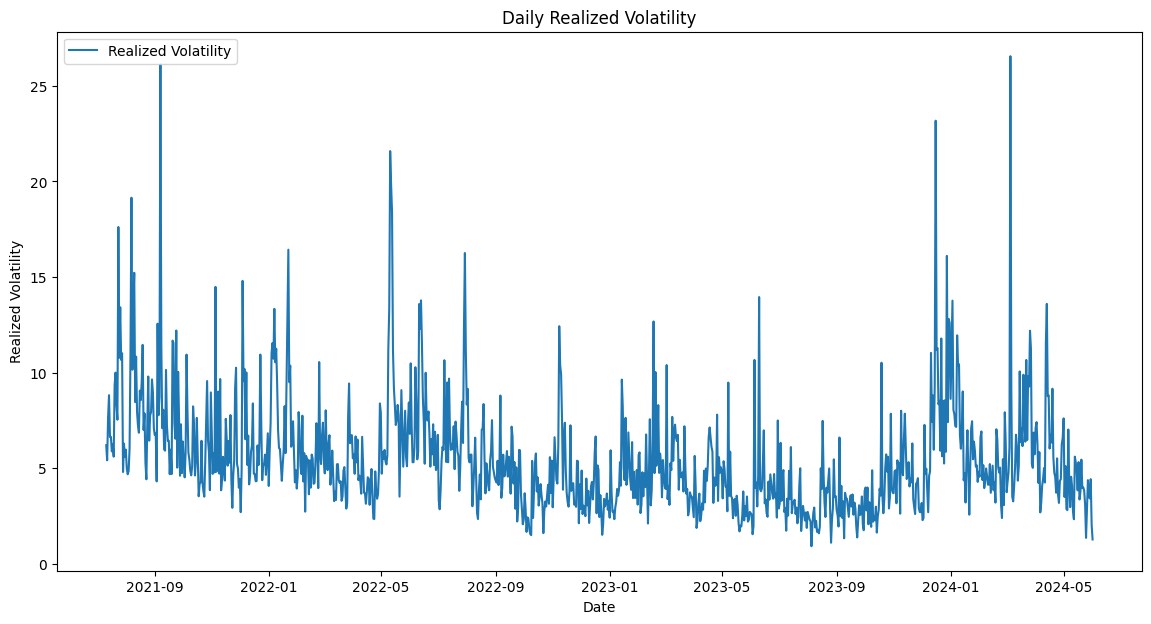

In [52]:
import importlib.util

packages_to_install = ['numpy', 'pandas', 'datetime', 'ta', 'matplotlib', 'IPython.utils']

for package in packages_to_install:
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        %pip install {package}

import ta
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def load_csvs(file_path):
    df = pd.read_csv(file_path)
    df.columns = [col.lower() for col in df.columns]
    df['date'] = pd.to_datetime(df['date'])
    df = df[['date'] + ['close']].dropna()
    df = df.iloc[::-1].reset_index(drop=True)
    df.set_index('date', inplace = True)
    df = df.sort_index()
    return df

def test_stationarity(feature_set):
    stationary_features = []
    non_stationary_features = []

    for column in feature_set.columns:
        # Perform Augmented Dickey-Fuller test
        if feature_set[column].min() != feature_set[column].max():
            result = adfuller(feature_set[column])
            p_value = result[1]

            # Check the p-value
            if p_value <= 0.05:
                stationary_features.append(column)
            else:
                non_stationary_features.append(column)
    return non_stationary_features

def handle_non_stationarity(feature_set):
    # Test for stationarity
    non_stationary_features = test_stationarity(feature_set)
    differencing = 0
    # Take differences until all features are stationary
    while non_stationary_features:
        differencing = differencing + 1
        for feature in non_stationary_features:
            # Take the first difference
            feature_set[feature] = feature_set[feature].diff().dropna()

        feature_set = feature_set.iloc[1:]

        # Test again for stationarity
        non_stationary_features = test_stationarity(feature_set)

    return feature_set, differencing

def obtainData(coin):
    print(coin)
    X_complete = []
    Y_complete = []

    #Get Data
    #drive.mount('/content/drive')
    data_path, minute_data_paths = get_filepaths(coin)
    data = pd.read_csv(data_path)
    data.columns = [col.lower() for col in data.columns]
    data.columns = [col.capitalize() for col in data.columns]
    data['Date'] = pd.to_datetime(data['Date'])
    features = ['Open', 'High', 'Low', 'Close', 'Volume eur']
    data = data[['Date'] + features].dropna()
    data = data.iloc[::-1].reset_index(drop=True)
    data.set_index('Date', inplace = True)

    #Get Intraday Data
    intraday_data = load_csvs(minute_data_paths)
    intraday_data.columns = [col.lower() for col in intraday_data.columns]
    intraday_data.columns = [col.capitalize() for col in intraday_data.columns]

    # High-Low
    data['High Minus Low'] = data['High'] - data['Low']

    #Realized Volatility
    realized_volatility = calculate_daily_realized_volatility(intraday_data)
    data["Realized Volatility Lag 1"]= realized_volatility.shift(1)

    for lag in range(1,5):
      data[f'Realized Volatility Lag {lag + 1}'] = data["Realized Volatility Lag 1"].shift(lag)

    data['Mean Realized Volatility Last 5'] = realized_volatility.rolling(window=5).mean()
    data['Mean Realized Volatility'] = realized_volatility.expanding().mean()

    # Lagged Returns
    data['Return Lag 1'] = np.log(data['Close']/data['Close'].shift(1))*100

    for lag in range(1, 5):
      data[f'Return Lag {lag+1}'] = data['Return Lag 1'].shift(lag)*100

    # Moving Average
    data['MA 5'] = data['Close'].rolling(window=5).mean()

    #Correlation MA and Lagged Return
    data['MA Close Correlation'] = data['Return Lag 1'].rolling(window=5).corr(data['MA 5'])

    #Relative Strength Index
    data['RSI 6'] = ta.momentum.RSIIndicator(close=data['Close'], window=6).rsi()
    data['RSI 14'] = ta.momentum.RSIIndicator(close=data['Close'], window=14).rsi()
    data['RSI > 80'] = ((data['RSI 6'] > 80) & (data['RSI 14'] > 80)).astype(int)
    data['RSI < 20'] = ((data['RSI 6'] < 20) & (data['RSI 14'] < 20)).astype(int)

    #EWMA
    data['EWMA'] = ta.trend.EMAIndicator(close=data['Close'], window=1 / (1 - 0.9)).ema_indicator()

    # Momentum
    data['Momentum'] = data['Close'].diff(5)

    # Calculate Aroon Up and Aroon Down
    data['Aroon Up'] = data['Close'].rolling(window=14).apply(lambda x: (14 - (x.argmax() + 1)) / 14 * 100)
    data['Aroon Down'] = data['Close'].rolling(window=14).apply(lambda x: (14 - (x.argmin() + 1)) / 14 * 100)

    # Calculate Aroon Stochastic Oscillator
    data['Aroon Oscillator'] = data['Aroon Up'] - data['Aroon Down']

    # Calculate Commodity Channel Index (CCI) with window = 14
    data['CCI'] = ta.trend.CCIIndicator(high=data['High'], low=data['Low'], close=data['Close'], window=14).cci()

    # Calculate Double Exponential Moving Average (DEMA) with window = 10
    data['DEMA'] = ta.trend.EMAIndicator(close=data['Close'], window=10).ema_indicator()

    # Rate of Change (ROC)
    data['ROC 9'] = ta.momentum.ROCIndicator(close=data['Close'], window=9).roc()
    data['ROC 14'] = ta.momentum.ROCIndicator(close=data['Close'], window=14).roc()

    # Average True Range (ATR)
    data['ATR 5'] = ta.volatility.AverageTrueRange(high=data['High'], low=data['Low'], close=data['Close'], window=5).average_true_range()
    data['ATR 10'] = ta.volatility.AverageTrueRange(high=data['High'], low=data['Low'], close=data['Close'], window=10).average_true_range()

    # Williams' %R
    data['Williams %R'] = ta.momentum.WilliamsRIndicator(high=data['High'], low=data['Low'], close=data['Close'], lbp=14).williams_r()

    # MACD
    macd = ta.trend.MACD(close=data['Close'], window_slow=10, window_fast=5, window_sign=5)
    data['MACD'] = macd.macd()

    # Sum past returns
    data['Sum Past Returns 3'] = data['Return Lag 1'].rolling(window=3).sum()
    data['Sum Past Returns 5'] = data['Return Lag 1'].rolling(window=5).sum()

    # Difference past returns
    data['Diff Past Returns 3'] = data['Return Lag 1'] - data['Return Lag 1'].shift(3)
    data['Diff Past Returns 5'] = data['Return Lag 1'] - data['Return Lag 1'].shift(5)

    # Add Bollinger Bands
    data['BB High'] = ta.volatility.bollinger_hband(data['Close'], window=20, window_dev=2)
    data['BB Low'] = ta.volatility.bollinger_lband(data['Close'], window=20, window_dev=2)

    # Add On-Balance Volume (OBV)
    data['On-Balance Volume'] = ta.volume.on_balance_volume(data['Close'], data['Volume eur'])

    # Add Stochastic Oscillator
    data['Stochastic Oscillator'] = ta.momentum.stoch(data['High'], data['Low'], data['Close'], window=14, smooth_window=3)

    # Add Keltner Channels
    data['Keltner High'] = ta.volatility.keltner_channel_hband(data['High'], data['Low'], data['Close'], window=20, window_atr=10)
    data['Keltner Low'] = ta.volatility.keltner_channel_lband(data['High'], data['Low'], data['Close'], window=20, window_atr=10)
    data['Keltner Middle'] = ta.volatility.keltner_channel_mband(data['High'], data['Low'], data['Close'], window=20, window_atr=10)

    # Add Volume-Weighted Average Price (VWAP)
    data['VWAP'] = ta.volume.volume_weighted_average_price(data['High'], data['Low'], data['Close'], data['Volume eur'], window=14)

    # Add Volatility Index (VIX) proxy using ATR
    data['VIX Proxy'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=14)

    # Ichimoku Cloud
    ichimoku_cloud = ta.trend.IchimokuIndicator(high=data['High'], low=data['Low'])
    data['Tenkan-sen'] = ichimoku_cloud.ichimoku_a()
    data['Kijun-sen'] = ichimoku_cloud.ichimoku_b()
    data['Senkou Span A'] = ichimoku_cloud.ichimoku_a()
    data['Senkou Span B'] = ichimoku_cloud.ichimoku_b()

    # Volume-Price Trend (VPT)
    data['Volume-Price Trend'] = ta.volume.VolumePriceTrendIndicator(close=data['Close'], volume=data['Volume eur']).volume_price_trend()

    #Start data from 2021
    data = data[data.index >= "2021-07-01"]
    data = data[data.index <= "2024-06-01"]

    initial_features = ['Open', 'High', 'Low', 'Close', 'Volume eur']
    ridge_data = data.drop(columns=initial_features)

    stationary_data, differencing = handle_non_stationarity(ridge_data)
    ##Subtract 22 days for the HAR-RV model
    start_time = pd.to_datetime('2021-08-01') + dt.timedelta(days = differencing) - dt.timedelta(days =22)
    stationary_data = stationary_data[stationary_data.index >= start_time]
    data = data[data.index >= start_time]
    realized_volatility = realized_volatility[realized_volatility.index >= start_time]
    realized_volatility = realized_volatility[realized_volatility.index <= "2024-06-01"]


    X_complete = data
    X_ridge = stationary_data
    Y_complete = realized_volatility

    return X_complete, Y_complete, X_ridge

def calculate_daily_realized_volatility(intraday_data):
    realized_volatility = pd.DataFrame()
    df_hourly = intraday_data.copy()

    # Calculate the returns
    df_hourly['Return'] = np.log(df_hourly['Close'] / df_hourly['Close'].shift(1))
    df_hourly['Squared Return'] = df_hourly['Return'] ** 2

    # Calculate daily realized volatility
    realized_volatility["Realized Volatility"] = df_hourly.groupby(df_hourly.index.date)['Squared Return'].sum().apply(np.sqrt) * 100
    realized_volatility.index = pd.to_datetime(realized_volatility.index)

    return realized_volatility

def plot_volatility(Y_complete):
    plt.figure(figsize=(14, 7))
    plt.plot(Y_complete.index, Y_complete.values, label='Realized Volatility')
    plt.xlabel('Date')
    plt.ylabel('Realized Volatility')
    plt.title('Daily Realized Volatility')
    plt.legend()
    plt.show()

coin = "Internet Computer"
X, Y, X_ridge = obtainData(coin)
plot_volatility(Y)


## Hypertuning

In [222]:
import optuna
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from tqdm.auto import tqdm

def objective(trial, model_name, X_train, Y_train, X_ridge=None):
    if model_name == "RandomForest":
        parameters = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 4, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 5)
        }
        model = RandomForestRegressor(**parameters)
    elif model_name == "LocalLinearForest":
        parameters = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 4, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 5),
            'lam' : trial.suggest_float('lam', 0.1, 10)
        }
        model = LocalLinearForestRegressor(**parameters)
        if X_ridge is not None:
            model._X_train_ridge = X_ridge

    # Perform cross-validation
    mse_scores = -cross_val_score(model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    mean_mse = mse_scores.mean()
    return mean_mse

def hypertune_model(model_name, X_train, Y_train, X_ridge=None, n_trials = 100):
    study = optuna.create_study(direction='minimize', pruner=SuccessiveHalvingPruner(), sampler=TPESampler(seed = 42))
    study.optimize(lambda trial: objective(trial, model_name, X_train, Y_train, X_ridge), n_trials=n_trials, show_progress_bar=True, n_jobs =-1)
    best_params = study.best_params
    print(model_name, best_params)
    return best_params

def run_hypertune(n_trials):
    coins = ["Bitcoin", "Ethereum", "Tether", "Binance Coin", "Bitcoin Cash", "Litecoin", "Internet Computer", "Polygon"]
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    results_rf = pd.DataFrame(columns=['Coin'])
    results_llf = pd.DataFrame(columns=['Coin'])

    for coin in tqdm(coins):
        X, Y, X_ridge = obtainData(coin)  # Assuming obtainData returns X, Y, X_ridge
        initial_train_size = 0.7
        train_size = int(len(X) * initial_train_size)
        X_train_split = X.iloc[:train_size].to_numpy()
        X_train_ridge = X_ridge.iloc[:train_size].to_numpy()
        Y_train = Y.iloc[:train_size].to_numpy().ravel()

        # Hyperparameter tuning for Random Forest
        best_rf_params = hypertune_model("RandomForest", X_train_split, Y_train, n_trials= n_trials)
        best_rf_params['Coin'] = coin
        print("Best RF Params:", best_rf_params)
        results_rf = pd.concat([results_rf, pd.DataFrame([best_rf_params])])

        # Hyperparameter tuning for Local Linear Forest
        best_llf_params = hypertune_model("LocalLinearForest", X_train_split, Y_train, X_train_ridge, n_trials = n_trials)
        best_llf_params['Coin'] = coin
        print("Best LLF Params:", best_llf_params)
        results_llf = pd.concat([results_llf, pd.DataFrame([best_llf_params])])

    # Convert DataFrame to LATEX tables
    latex_table_rf = results_rf.to_latex(index=False, float_format="%.3f")
    latex_table_llf = results_llf.to_latex(index=False, float_format="%.3f")

    print(latex_table_rf)
    print(latex_table_llf)

#run_hypertune()


## Descriptive Statistics

In [53]:
def calculate_descriptive_statistics(data):
    data['returns'] = np.log(data['Close'] / data['Close'].shift(1)).dropna()
    data['returns'] = data['returns']*100
    descriptive_stats = {
        'Mean Returns': data['returns'].mean(),
        'Median Returns': data['returns'].median(),
        'Highest Returns': data['returns'].max(),
        'Lowest Returns': data['returns'].min(),
        'Standard Deviation of Returns': data['returns'].std(),
        'Skewness of Returns': data['returns'].skew(),
        'Kurtosis of Returns': data['returns'].kurt(),
        'Number of Observations': data['returns'].count()
    }
    return pd.DataFrame(descriptive_stats, index=[0])

coins = ["Bitcoin", "Ethereum", "Tether", "Binance Coin", "Bitcoin Cash", "Litecoin", "Internet Computer", "Polygon"]

# DataFrame to store descriptive statistics for all coins
all_descriptive_stats = pd.DataFrame()

for coin in coins:
    X, Y, X_ridge = obtainData(coin)
    descript_stats = calculate_descriptive_statistics(X)
    descript_stats['Coin'] = coin
    all_descriptive_stats = pd.concat([all_descriptive_stats, descript_stats], ignore_index=True)

# Reorder columns to have 'Coin' as the first column
all_descriptive_stats = all_descriptive_stats[['Coin'] + [col for col in all_descriptive_stats.columns if col != 'Coin']]

# Print the DataFrame as a LaTeX table
print(all_descriptive_stats.to_latex(index=False, float_format="%.3f"))

Bitcoin
Ethereum
Tether
Binance Coin
Bitcoin Cash
Litecoin
Internet Computer
Polygon
\begin{tabular}{lrrrrrrrr}
\toprule
Coin & Mean Returns & Median Returns & Highest Returns & Lowest Returns & Standard Deviation of Returns & Skewness of Returns & Kurtosis of Returns & Number of Observations \\
\midrule
Bitcoin & 0.073 & 0.055 & 13.144 & -15.828 & 2.891 & -0.331 & 3.569 & 1056 \\
Ethereum & 0.063 & 0.060 & 16.249 & -18.353 & 3.608 & -0.301 & 3.624 & 1056 \\
Tether & -0.008 & 0.000 & 2.062 & -1.739 & 0.464 & 0.144 & 1.838 & 1056 \\
Binance Coin & 0.068 & 0.094 & 15.795 & -19.975 & 3.303 & -0.511 & 4.731 & 1056 \\
Bitcoin Cash & 0.002 & -0.050 & 46.024 & -18.295 & 4.452 & 1.417 & 15.172 & 1056 \\
Litecoin & -0.036 & 0.084 & 24.176 & -21.283 & 4.086 & -0.229 & 4.153 & 1056 \\
Internet Computer & -0.104 & -0.011 & 33.734 & -35.497 & 5.455 & 0.325 & 5.438 & 1056 \\
Polygon & -0.029 & -0.110 & 29.900 & -28.212 & 5.226 & 0.252 & 4.352 & 1056 \\
\bottomrule
\end{tabular}



## In-Sample Forecast


In [225]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from tqdm import tqdm, notebook
from IPython.utils import io

def in_sample_forecast(X_complete, Y_complete, X_ridge):
    predictions = {}
    LLF_pred = []
    RF_pred = []
    GJR_pred = []
    GARCH_pred = []

    #Get Dates
    har_Y = Y_complete
    Y_complete = Y_complete.iloc[21:]
    Y_complete_dates = Y_complete.index
    X_ridge = X_ridge.iloc[21:]
    X_complete = X_complete.iloc[20:]
    
    #Get returns
    returns = np.log(X_complete['Close'] / X_complete['Close'].shift(1)).dropna()
    returns = returns * 100

    X_complete = X_complete.iloc[1:]

    #Set to correct format
    X_complete = X_complete.to_numpy()
    X_ridge = X_ridge.to_numpy()
    Y_complete = Y_complete.to_numpy().ravel()

    # Local Linear Forest
    LLF_parameters = hypertune_model("LocalLinearForest", X_complete, Y_complete, X_ridge, n_trials = 100)
    LLF = LocalLinearForestRegressor(**LLF_parameters)
    LLF.fit(X_complete, Y_complete, X_ridge)
    LLF_pred = LLF.predict_LLF(X_complete, X_ridge)
    predictions['LLF'] = pd.Series(LLF_pred, index=Y_complete_dates)

    # Random Forest
    RF_parameters = hypertune_model("RandomForest", X_complete, Y_complete, n_trials = 100)    
    RF_pred = train_test_rf(X_complete, Y_complete, X_complete, **RF_parameters)
    predictions['RF'] = pd.Series(RF_pred, index=Y_complete_dates)

    # GARCH(1,1)
    GARCH_pred = predict_GARCH(returns, False)
    predictions['GARCH'] = pd.Series(GARCH_pred, index=Y_complete_dates)

    # GJR-GARCH
    GJR_pred = predict_GJR(returns, False)
    predictions['GJR'] = pd.Series(GJR_pred, index=Y_complete_dates)

    #HAR-RV
    har_pred = predict_har(har_Y)
    predictions['HAR-RV'] = pd.Series(har_pred, index=Y_complete_dates)

    return predictions, Y_complete


## Out-Of-Sample Forecast

In [224]:
#%pip install model-confidence-set
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm, notebook
from IPython.utils import io


def forecast(X_complete, Y_complete, X_ridge, initial_train_size, feature = True):
    predictions = {}
    LLF_pred = []
    RF_pred = []
    GJR_pred = []
    GARCH_pred = []
    HAR_pred = []

    #Get Dates
    har_Y = Y_complete
    Y_complete = Y_complete.iloc[21:]
    X_ridge = X_ridge.iloc[21:]
    X_complete = X_complete.iloc[21:]

    train_size = int(len(X_complete) * initial_train_size)
    test_size = len(X_complete) - train_size
    Y_dates = Y_complete.iloc[train_size:].index
    feature_names =  X_complete.columns
    feature_importance = np.zeros(len(feature_names))

    #Hyperparameter Tuning
    X_tune = X_complete.iloc[:train_size].to_numpy()
    Y_tune = Y_complete.iloc[:train_size].to_numpy().ravel()
    X_ridge_tune = X_ridge.iloc[:train_size].to_numpy()
    LLF_parameters = hypertune_model("LocalLinearForest", X_tune, Y_tune, X_ridge_tune, 100)
    RF_parameters = hypertune_model("RandomForest", X_tune, Y_tune, n_trials = 100)

    for i in notebook.tqdm(range(test_size)):
        X_train_split = X_complete.iloc[:train_size + i]
        X_train_ridge = X_ridge.iloc[:train_size + i]
        returns = np.log(X_train_split['Close'] / X_train_split['Close'].shift(1)).dropna()
        returns = returns * 100
        X_train_split = X_train_split.to_numpy()
        X_train_ridge = X_train_ridge.to_numpy()
        X_test_split = X_complete.iloc[train_size + i : train_size + i + 1].to_numpy()
        X_test_ridge = X_ridge.iloc[train_size + i : train_size + i + 1].to_numpy()
        Y_train = Y_complete.iloc[:train_size + i].to_numpy().ravel()
        Y_test =  Y_complete.iloc[train_size + i : train_size + i + 1].to_numpy().ravel()
        
        # Local Linear Forest
        LLF = LocalLinearForestRegressor(**LLF_parameters)
        LLF.fit(X_train_split, Y_train, X_train_ridge)
        LLF_pred.append(max(LLF.predict_LLF(X_test_split, X_test_ridge)[0], 0.1))
        feature_importance = feature_importance + LLF.feature_importances_

        # Random Forest
        RF_pred.append(train_test_rf(X_train_split, Y_train, X_test_split, **RF_parameters)[0])

        # GJR-GARCH
        GJR_pred.append(predict_GJR(returns, True))

        #GARCH(1,1)
        GARCH_pred.append(predict_GARCH(returns, True))

        # HAR-RV
        har_data = har_Y.iloc[:train_size + i + 21]
        HAR_pred.append(predict_har(har_data))

    if feature: 
       feature_importance = feature_importance / test_size
       plot_feature_importance(feature_importance, feature_names, threshold = 0.005)

    predictions['LLF'] = pd.Series(LLF_pred, index=Y_dates)
    predictions['RF'] = pd.Series(RF_pred, index=Y_dates)
    predictions['GARCH'] = pd.Series(GARCH_pred, index=Y_dates)
    predictions['GJR'] = pd.Series(GJR_pred, index=Y_dates)
    predictions['HAR-RV'] = pd.Series(HAR_pred, index = Y_dates)
    Y_test = Y_complete.iloc[train_size:]

    return predictions, Y_test

## Utility Benefits

In [165]:
import numpy as np

def utility(forecast, realized_volatility):
  realized_volatility = realized_volatility.squeeze()
  return 0.08 * (np.sqrt(realized_volatility/forecast)) - 0.04 * (realized_volatility/forecast)

def calculate_weight(sharpe, gamma, forecast):
    x_t = (sharpe/gamma) /np.sqrt(forecast)
    return x_t

def expected_utility(forecasts, realized_volatilities):
    total_utility = 0
    for date, forecast in forecasts.items():
        realized_volatility = realized_volatilities.loc[date].iloc[0]

        utility_i = utility(forecast, realized_volatility)
        total_utility += utility_i

    expected_utility = total_utility / len(forecasts)

    return expected_utility

## Market Cycles

In [175]:
if importlib.util.find_spec("scikit_posthocs") is None:
        %pip install {"scikit_posthocs"}
import pandas as pd
import numpy as np
from scipy.stats import f_oneway, skew, kruskal
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from IPython.utils import io

def define_market_phases(prices, window=30, threshold=0.05):
    moving_avg = prices.rolling(window).mean()
    change = (prices - moving_avg) / moving_avg
    market_phases = np.where(change > threshold, 'bull', np.where(change < -threshold, 'bear', 'consolidating'))
    return pd.Series(market_phases, index=prices.index)

def segment_data_by_phases(errors, market_phases):
    phases_data = {model: {'bull': [], 'bear': [], 'consolidating': []} for model in errors.keys()}
    phase_counts = {'bull': 0, 'bear': 0, 'consolidating': 0}

    for phase in ['bull', 'bear', 'consolidating']:
        phase_indices = market_phases[market_phases == phase].index
        phase_counts[phase] = len(phase_indices)
        for model, model_errors in errors.items():
            phase_indices_model = phase_indices.intersection(errors[model].index)
            phase_data = model_errors.loc[phase_indices_model]
            phases_data[model][phase] = phase_data.tolist()

    return phases_data, phase_counts

def perform_kruskal(errors_by_phase):
    results = {}
    for model, phase_errors in errors_by_phase.items():
        stat, p_value = kruskal(phase_errors['bull'], phase_errors['bear'], phase_errors['consolidating'])
        results[model] = {'stat': stat, 'p_value': p_value}
    return results

def perform_dunn_test(errors_by_phase):
    results = {}
    for model, phase_errors in errors_by_phase.items():
        dunn = sp.posthoc_dunn([phase_errors['bull'], phase_errors['bear'], phase_errors['consolidating']], p_adjust='bonferroni')
        results[model] = dunn
    return results

def cycle_errors(predictions, Y_test):
    errors = {}
    for model, pred in predictions.items():
        Y_test = Y_test.squeeze()
        errors[model] = (pred - Y_test) ** 2
    return errors



## Perform Forecasts

In [227]:
def perform_models(coins, in_sample, training_size=0.7):
    results = {
        'coin': [],
        'LLF_rmse': [], 'RF_rmse': [], 'GARCH_rmse': [], 'GJR_rmse': [], 'HAR-RV_rmse': [],
        'LLF_mae': [], 'RF_mae': [], 'GARCH_mae': [], 'GJR_mae': [], 'HAR-RV_mae': [],
        'LLF_qlike': [], 'RF_qlike': [], 'GARCH_qlike': [], 'GJR_qlike': [], 'HAR-RV_qlike': []
    }

    mcs_counts_rmse = {model: 0 for model in ['LLF', 'RF', 'GARCH', 'GJR', 'HAR-RV']}
    mcs_counts_qlike = {model: 0 for model in ['LLF', 'RF', 'GARCH', 'GJR', 'HAR-RV']}
    mcs_counts_utility = {model: 0 for model in ['LLF', 'RF', 'GARCH', 'GJR', 'HAR-RV']}
    mcsr_rmse = {}
    mcsr_qlike = {}
    mcsr_utility = {}

    for coin in notebook.tqdm(coins):
        print(coin)
        with io.capture_output() as captured:
            X, Y, X_ridge = obtainData(coin)
        if in_sample:
            predictions, Y_test = in_sample_forecast(X, Y, X_ridge)
        else:
            predictions, Y_test = forecast(X, Y, X_ridge, training_size)
        
        mse, mae, rmse = get_errors(predictions, Y_test)
        qlike = get_qlike(predictions, Y_test)

        results['coin'].append(coin)
        for metric, res_dict in zip(['rmse', 'mae', 'qlike'], [rmse, mae, qlike]):
            for model in ['LLF', 'RF', 'GARCH', 'GJR', 'HAR-RV']:
                results[f'{model}_{metric}'].append(res_dict[model])

        mcs_counts_rmse, mcs_counts_qlike, mcs_counts_utility = update_mcs_count(
            predictions, Y_test, mcs_counts_rmse=mcs_counts_rmse, mcs_counts_qlike=mcs_counts_qlike, mcs_counts_utility=mcs_counts_utility
        )

        print('rmse', rmse)
        print('qlike', qlike)
        print('counts', mcs_counts_rmse, mcs_counts_qlike, mcs_counts_utility)
        
        if not in_sample:
            # Define market phases
            market_phases = define_market_phases(X['Close'])
            total_errors = cycle_errors(predictions, Y_test)
            errors_by_phase, phase_counts = segment_data_by_phases(total_errors, market_phases)

            # Print the number of observations in each phase
            print("Number of observations in each phase:")
            for phase, count in phase_counts.items():
                print(f"{phase}: {count}")

            if coin != 'Tether':
                # Perform Kruskal-Wallis and Dunn's tests
                kruskal_results = perform_kruskal(errors_by_phase)
                dunn_results = perform_dunn_test(errors_by_phase)

                # Print statistics, Kruskal-Wallis results, and Dunn's test results for each model
                for model, phase_data in errors_by_phase.items():
                    print(f"Statistics for model {model} on coin {coin}:")
                    for phase, errors in phase_data.items():
                        errors_array = np.array(errors)
                        print(f"{phase}:")
                        print(f"  Mean: {np.mean(errors_array)}")
                        print(f"  Standard Deviation: {np.std(errors_array)}")
                        print(f"  Skewness: {skew(errors_array)}")

                    # Print Kruskal-Wallis results
                    kruskal_result = kruskal_results[model]
                    print(f"\nKruskal-Wallis results for model {model} on coin {coin}:")
                    print(f"Statistic = {kruskal_result['stat']}, p-value = {kruskal_result['p_value']}")

                    # Print Dunn's test results
                    dunn_result = dunn_results[model]
                    print(f"\nDunn's test results for model {model} on coin {coin} (p-values):")
                    print(dunn_result)
    
    # Calculate MCSR
    for model in predictions.keys():
        mcsr_rmse[model] = mcs_counts_rmse[model] / len(coins)
        mcsr_qlike[model] = mcs_counts_qlike[model] / len(coins)
        mcsr_utility[model] = mcs_counts_utility[model] / len(coins)

    results_df = pd.DataFrame(results)

    # Generate and print LaTeX tables
    latex_tables = {
        'RMSE': results_df[['coin', 'LLF_rmse', 'RF_rmse', 'GARCH_rmse', 'GJR_rmse', 'HAR-RV_rmse']].to_latex(index=False, float_format="%.3f"),
        'MAE': results_df[['coin', 'LLF_mae', 'RF_mae', 'GARCH_mae', 'GJR_mae', 'HAR-RV_mae']].to_latex(index=False, float_format="%.3f"),
        'QLIKE': results_df[['coin', 'LLF_qlike', 'RF_qlike', 'GARCH_qlike', 'GJR_qlike', 'HAR-RV_qlike']].to_latex(index=False, float_format="%.3f"),
        'MCS Counts': pd.DataFrame([mcsr_rmse, mcsr_qlike, mcsr_utility], index=['RMSE', 'QLIKE', 'Utility']).to_latex(float_format="%.3f")
    }
    
    return latex_tables

coins = ["Bitcoin", "Ethereum", "Tether", "Binance Coin", "Bitcoin Cash", "Litecoin", "Internet Computer", "Polygon"]

# In-sample Forecasts
latex_tables_in_sample = perform_models(coins, in_sample=True)
for name, table in latex_tables_in_sample.items():
    print(f"{name} Table:")
    print(table)

# Out-of-Sample Forecasts
latex_tables_out_sample = perform_models(coins, in_sample=False, training_size=0.70)
for name, table in latex_tables_out_sample.items():
    print(f"{name} Table:")
    print(table)

  0%|          | 0/8 [00:00<?, ?it/s]

Bitcoin


  0%|          | 0/100 [00:00<?, ?it/s]

LocalLinearForest {'n_estimators': 261, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 3, 'lam': 1.2021009459672352}


  0%|          | 0/100 [00:00<?, ?it/s]

RandomForest {'n_estimators': 432, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 3}
rmse {'LLF': 0.33831356446416544, 'RF': 0.35873616412772863, 'GARCH': 1.5687686427836331, 'GJR': 1.566283444242782, 'HAR-RV': 1.7092171112536745}
qlike {'LLF': 0.01577006375488966, 'RF': 0.006852535252508065, 'GARCH': 0.20963702985313204, 'GJR': 0.20999203199254798, 'HAR-RV': 0.28617590273957305}
counts {'LLF': 1, 'RF': 1, 'GARCH': 0, 'GJR': 0, 'HAR-RV': 0} {'LLF': 0, 'RF': 1, 'GARCH': 0, 'GJR': 0, 'HAR-RV': 0} {'LLF': 0, 'RF': 1, 'GARCH': 0, 'GJR': 0, 'HAR-RV': 0}
Ethereum


  0%|          | 0/100 [00:00<?, ?it/s]

LocalLinearForest {'n_estimators': 117, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'lam': 2.6820758105874787}


  0%|          | 0/100 [00:00<?, ?it/s]

## Large-Cap vs. Small-Cap Coins

In [ ]:
import pandas as pd
from scipy.stats import skew

def normalized_errors(predictions, Y_test):
    predictions = predictions.reset_index(drop=True)
    Y_test = Y_test.reset_index(drop=True)
    if isinstance(Y_test, pd.DataFrame):
        Y_test = Y_test.iloc[:, 0]
    if isinstance(predictions, pd.DataFrame):
        predictions = predictions.iloc[:, 0]
    return (np.log(predictions/Y_test)) ** 2

def get_grouped_errors(coins, large_cap_coins, mid_cap_coins):
    large_cap_errors = {model: [] for model in ["LLF", "RF", "GJR", "GARCH", "HAR-RV"]}
    mid_cap_errors = {model: [] for model in ["LLF", "RF", "GJR", "GARCH", "HAR-RV"]}

    for coin in notebook.tqdm(coins):
        print(coin)
        with io.capture_output() as captured:
            X, Y, X_ridge = obtainData(coin)
        predictions, Y_test = forecast(X, Y, X_ridge, 0.70, False)
        for model, model_predictions in predictions.items():
            norm_errors = normalized_errors(model_predictions, Y_test)
            if coin in large_cap_coins:
                large_cap_errors[model].append(norm_errors)
            elif coin in mid_cap_coins:
                mid_cap_errors[model].append(norm_errors)

    for model in large_cap_errors:
        # Concatenate errors for all large cap coins and calculate statistics
        combined_errors = pd.concat(large_cap_errors[model], axis=0, ignore_index=True)
        large_cap_errors[model] = {
            'RMSLE': np.sqrt(combined_errors.mean()),
            'std': combined_errors.std(),
            'skew': skew(combined_errors.dropna())
        }

    for model in mid_cap_errors:
        combined_errors = pd.concat(mid_cap_errors[model], axis=0, ignore_index=True)
        mid_cap_errors[model] = {
            'RMSLE': np.sqrt(combined_errors.mean()),
            'std': combined_errors.std(),
            'skew': skew(combined_errors.dropna())
        }

    return large_cap_errors, mid_cap_errors

coins = ["Bitcoin", "Ethereum", "Tether", "Binance Coin", "Bitcoin Cash", "Litecoin", "Internet Computer", "Polygon"]
# Define large-cap and mid-cap groups
large_cap_coins = ["Bitcoin", "Ethereum", "Tether", "Binance Coin"]
mid_cap_coins = ["Bitcoin Cash", "Litecoin", "Internet Computer", "Polygon"]

large_cap_errors, mid_cap_errors = get_grouped_errors(coins, large_cap_coins, mid_cap_coins)

print("Large Cap Errors:")
print(large_cap_errors)
print("\nMid Cap Errors:")
print(mid_cap_errors)


  0%|          | 0/8 [00:00<?, ?it/s]

Bitcoin


  0%|          | 0/107 [00:00<?, ?it/s]

Ethereum


  0%|          | 0/107 [00:00<?, ?it/s]

Tether


  0%|          | 0/107 [00:00<?, ?it/s]

Binance Coin


  0%|          | 0/107 [00:00<?, ?it/s]

Bitcoin Cash


  0%|          | 0/107 [00:00<?, ?it/s]

Litecoin


  0%|          | 0/107 [00:00<?, ?it/s]

Internet Computer


  0%|          | 0/107 [00:00<?, ?it/s]

Polygon


  0%|          | 0/107 [00:00<?, ?it/s]

Large Cap Errors:
{'LLF': {'mean': 0.3611557366962622, 'std': 0.7985219380498657, 'skew': 5.2415290678911015}, 'RF': {'mean': 0.3709975552136856, 'std': 0.8200721707839111, 'skew': 5.1131012445921415}, 'GJR': {'mean': 0.40903927992813355, 'std': 0.854713456396852, 'skew': 4.327099143669474}, 'GARCH': {'mean': 0.414368739051379, 'std': 0.852164474177923, 'skew': 4.228621018890301}, 'HAR-RV': {'mean': 0.5361995496849574, 'std': 0.9830502459227625, 'skew': 5.1919539331482305}}

Mid Cap Errors:
{'LLF': {'RMSLE': 0.4406057381316043, 'std': 0.29217782222689204, 'skew': 3.1077940530354433}, 'RF': {'RMSLE': 0.46181168768981606, 'std': 0.3063896086715535, 'skew': 2.6523131437797662}, 'GJR': {'RMSLE': 0.48494041590319775, 'std': 0.416341987744906, 'skew': 5.398465687098967}, 'GARCH': {'RMSLE': 0.4806725759628846, 'std': 0.40485422041273833, 'skew': 5.065922622764456}, 'HAR-RV': {'RMSLE': 0.650443502602148, 'std': 0.6891267725607493, 'skew': 4.37352488547282}}
